In [55]:
# importing necessary libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random

In [56]:
# extracting and preprocessing data
import os

filenames = os.listdir('DVCData/train')
labels = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        labels.append(str(1))
    else:
        labels.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

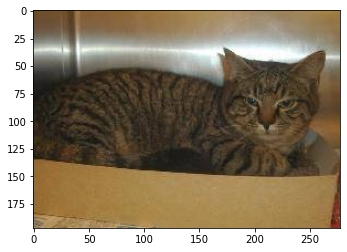

cat.7406.jpg


In [57]:
#visualizing a random data
sample = random.choice(filenames)
image = load_img("DVCData/train/"+sample)
plt.imshow(image)
plt.show()
print(sample)

In [58]:
# splitting the training data into training and validation

train_data, val_data = train_test_split(df, test_size=0.2, random_state = 42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# print(train_data['label'].value_counts())
# print(val_data['label'].value_counts())

In [59]:
# generating and augmentating training and validation data through ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    "DVCData/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    batch_size=20
)

val_data_gen = ImageDataGenerator(rescale=1./255)

val_generator = val_data_gen.flow_from_dataframe(val_data, 
    "DVCData/train/", 
    x_col='filename',
    y_col='label',
    target_size=(128,128),
    class_mode='binary',
    batch_size=20
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [60]:
# defining the model

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, input_shape = (128,128,3), padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, padding= 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation ='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)       

In [ ]:
hmodel = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=6, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/6
 419/1000 [===========>..................] - ETA: 5:06 - loss: 0.6949 - binary_accuracy: 0.5137

In [61]:
# code to show the training and validation output for Gender model.

accuracy = hmodel.history['binary_accuracy']
val_accuracy = hmodel.history['val_binary_accuracy']
loss = hmodel.history['loss']
val_loss = hmodel.history['val_loss']
epochs = range(len(accuracy))

fig = plt.figure(figsize=(10,8)) 
plt.plot(epochs, accuracy, 'b', label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
# txt = "Fig 1.b : "               # captioning the figure
# fig.text(.5, .05, txt, ha='center')
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'b', label = 'Training accuracy')
plt.plot(epochs,val_loss,'r', label= 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

NameError: name 'hmodel' is not defined

In [ ]:
# code to test Gender Classfication model

# creating test generator to test the model
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'DVC/test/',
    target_size=(128, 128),
    class_mode=None,
    shuffle=False,
    batch_size=50,
)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

# model.evaluate_generator(generator=valid_generator,
# steps=STEP_SIZE_VALID)

#predicting output label for test dataset
pred = model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# converting the predicted output data and getting desired ouput
animal_pred = [ (1 if y[0] > 0.5 else 0) for y in pred]
animal_desired = test_generator.classes

# # labels = (train_generator.class_indices)
# # labels = dict((v,k) for k,v in labels.items())
# # predictions = [labels[k] for k in y_pred]

# saving the predicted output in a text file
examplenames=test_generator.filenames
results=pd.DataFrame({"Filenames":examplenames, "Desired Output": animal_desired, "Predicted Output": animal_pred})
results.to_csv("animal_prediction.txt", header= False, index= False, sep =' ')
